# Notebook for generating plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from functions import Ridge_parameters
from functions import find_MSE_Ridge_predict_poly_ridgelambda
from functions import polynomial_features

from runge_function import Runge_func

In [2]:
n = 100
x = np.linspace(-1, 1, n)
y = Runge_func(x) + np.random.normal(0, 1, size=n)

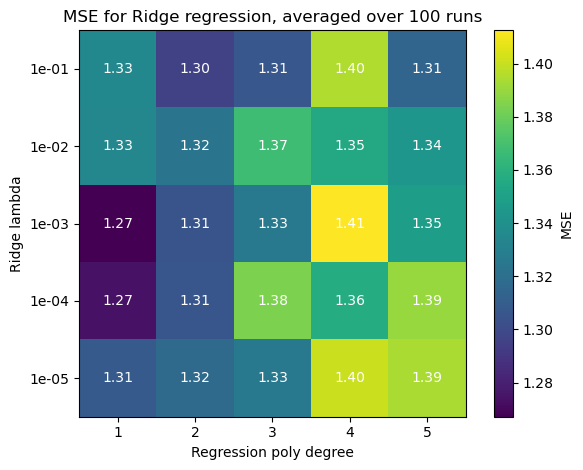

In [ ]:
poly_min = 1
poly_max = 5
poly_degrees = np.arange(poly_min, poly_max + 1, 1)

exp_start = -1
exp_stop = -5
ridge_lambdas = np.logspace(exp_start, exp_stop, abs(exp_stop-exp_start)+1) # takes 1e(exp_start) and 1e(exp_stop) as arguments, 1e1 as steps

runs = 100    # Numbers of times we calculate the MSE matrix
MSE_polys_ridgelambdas_matrix = np.zeros((len(ridge_lambdas), len(poly_degrees), runs)) # 3d array, each run store the poly-lambda-plane

for k in range(runs):
    for j in range(len(poly_degrees)):
        for i in range(len(ridge_lambdas)):
            MSE_Ridge_poly_ridgelambda = find_MSE_Ridge_predict_poly_ridgelambda(x, y, poly_degrees[j], ridge_lambdas[i])
            MSE_polys_ridgelambdas_matrix[i,j,k] = MSE_Ridge_poly_ridgelambda


# Taking the mean over all the runs, element vise
mean_MSE = np.copy(np.mean(MSE_polys_ridgelambdas_matrix, axis=2))

# Creating heatmap, copied from from Copilot answers and tweaked

fig, ax = plt.subplots()

# Display the heatmap using the Axes object
im = ax.imshow(mean_MSE, cmap='viridis', interpolation='nearest')

# Annotate each cell with its value
for i in range(mean_MSE.shape[0]):
    for j in range(mean_MSE.shape[1]):
        value = mean_MSE[i, j]
        ax.text(j, i, f"{value:.2f}", ha="center", va="center", color="white")

# Set axis ticks and labels
ax.set_xticks(np.arange(len(poly_degrees)))
ax.set_xticklabels(poly_degrees)
ax.set_yticks(np.arange(len(ridge_lambdas)))
ax.set_yticklabels([f"{lam:.0e}" for lam in ridge_lambdas])

# Add colorbar and labels
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('MSE')

#ax.set_title(f"MSE for Ridge regression, averaged over {runs} runs")
ax.set_xlabel("Regression poly degree")
ax.set_ylabel("Ridge lambda")

plt.tight_layout()

# Make plot latex report friendly
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.size': 13,
    'axes.titlesize': 13,
    'axes.labelsize': 13,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 12,
})

plt.savefig("heatmap_ridge.pdf", bbox_inches="tight")
plt.show()
plt.close()